In [25]:
#my modules
import wrangle as wr
import explore as ex

#Imports
import pandas as pd
import numpy as np

import nltk
# nltk.download('words')
# words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to
[nltk_data]     /Users/alexia.lewis/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
df = wr.check_file_exists_gbq('cfpb.csv', 'service_key.json')

csv file found and loaded


## Initial Thoughts

* There are going to be key words that match to a companies response
* Sentiment analysis will not be useful because most complaints will likely be negative

## Questions

1. Do specific issues tend to receive specific responses? For example, do issues related to fraud tend to receive more "closed with relief" responses compared to other issues?
2. Is there a relationship between consumer complaint and company response?
3. Do narratives with a neutral or positive sentiment analysis relating to bank account products lead to a response of closed with monetary relief?
4. Are there unique words associated with the most negative and most positive company response?
5. Is there a relationship/bias for servicemember tags in relation to company response?
6. Does narrative length relate to company response?

In [3]:
pd.set_option("display.max_colwidth", 250)

In [4]:
df_clean = wr.clean_data(df)
df_clean.to_parquet('df_clean.parquet')
df_clean = pd.read_parquet('df_clean.parquet')

df_prep = wr.prep_narrative(df_clean)
df_prep.to_parquet('df_prep.parquet')
df_prep = pd.read_parquet('df_prep.parquet')

train, validate, test = wr.split_data(df_prep,"company_response_to_consumer")

train.to_parquet('train.parquet')
validate.to_parquet('validate.parquet')
test.to_parquet('test.parquet')

train = pd.read_parquet('train.parquet')
validate = pd.read_parquet('validate.parquet')
test = pd.read_parquet('test.parquet')

Prepared DF: (1246736, 8)
Train: (748041, 8)
Validate: (249347, 8)
Test: (249348, 8)


In [5]:
train.head(1)

,date_received,company_name,state,tags,company_response_to_consumer,product_bins,clean,lemon
944870,2015-05-12,"CITIBANK, N.A.",CA,Average Person,Closed with monetary relief,mortgage,it has been since that i first applied for the refinance as of today no decision or counter offer has been conveyed to me it s not a new loan and i am not a new customer to citibank my home loan is currently with citibank and has been for the pas...,since first applied refinance today decision counter offer conveyed new loan new customer citibank home loan currently citibank past several year week requested something provided item requested would get phone call requesting item response email...


In [6]:
# df.company_response_to_consumer.value_counts()

## 2. Is there a relationship between consumer complaint words and company response?

In [51]:
#text
import re
import unicodedata
import nltk

#for viz
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


def basic_clean(string):
    """
    The function `basic_clean` takes a string as input and performs basic cleaning operations such as
    converting the string to lowercase, removing non-alphanumeric characters, and normalizing unicode
    characters.
    
    :param string: The parameter "string" is a string that you want to perform basic cleaning on
    :return: The function `basic_clean` returns a cleaned version of the input string.
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii','ignore').decode('utf-8')
    string = re.sub(r'[^a-z0-9\'\s]', ' ', string).split()
    return string

def get_words(train):
    '''
    this function extracts and counts words from a df based on different company responses.
    returns a word_count df containing the associated words for each response
    '''
    #assinging all words to proper labels
    explanation_words = basic_clean(' '.join(train[train.company_response_to_consumer == 'Closed with explanation'].lemon))
    no_money_words = basic_clean(' '.join(train[train.company_response_to_consumer == 'Closed with non-monetary relief'].lemon))
    money_words = basic_clean(' '.join(train[train.company_response_to_consumer == 'Closed with monetary relief'].lemon))
    timed_out_words = basic_clean(' '.join(train[train.company_response_to_consumer == 'Untimely response'].lemon))
    closed_words = basic_clean(' '.join(train[train.company_response_to_consumer == 'Closed'].lemon))
    all_words = basic_clean(' '.join(train.lemon))
    
    #grabbing frequencies of occurences
    explanation_freq = pd.Series(explanation_words).value_counts()
    no_money_freq = pd.Series(no_money_words).value_counts()
    money_freq = pd.Series(money_words).value_counts()
    timed_out_freq = pd.Series(timed_out_words).value_counts()
    closed_freq = pd.Series(closed_words).value_counts()
    all_freq = pd.Series(all_words).value_counts()

    #combine into df to see all words and languages together
    word_counts = (pd.concat([all_freq, explanation_freq, no_money_freq, money_freq, timed_out_freq, closed_freq], axis=1, sort=True)
                .set_axis(['all', 'explanation', 'no_money', 'money', 'timed_out', 'closed'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
    
    print(f"Total Unique Words Found per Response: {word_counts.shape[0]}")
    print()
    
    return word_counts

In [52]:
word_counts = get_words(train)

Total Unique Words Found per Response: 122304



In [53]:
word_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122304 entries, aa to zzzzzzzzz
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   all          122304 non-null  int64
 1   explanation  122304 non-null  int64
 2   no_money     122304 non-null  int64
 3   money        122304 non-null  int64
 4   timed_out    122304 non-null  int64
 5   closed       122304 non-null  int64
dtypes: int64(6)
memory usage: 6.5+ MB


In [55]:
word_counts.sort_values(by='all',ascending=False).head(25)

,all,explanation,no_money,money,timed_out,closed
account,1390487,1045109,257905,82549,2515,2409
credit,1333790,1028932,259158,40958,2668,2074
report,758566,576165,172216,7725,1389,1071
information,640808,485884,140081,12109,1658,1076
payment,602762,499750,60288,39111,1851,1762
reporting,477945,353066,122131,1738,658,352
consumer,429900,308212,116461,4191,680,356
loan,388416,344588,27089,12999,2266,1474
time,378257,302788,44984,27909,1360,1216
would,366847,292951,35183,35449,1811,1453


In [122]:
def unique_words(word_counts):
    '''
    '''
    # setting basic style parameters for matplotlib
    plt.rc('figure', figsize=(13, 7))
    plt.style.use('seaborn-darkgrid')

    # Iterate over the columns of word_counts
    for i, col in enumerate(word_counts.columns):
        plt.subplot(3, 3, i+1)  # Adjust the subplot parameters as per your requirement

        # Sort the values in the column in descending order and select the top 5
        top_words = word_counts[col].sort_values(ascending=False).head(3)

        # Create a horizontal bar plot
        top_words.plot.barh()

        plt.xlabel('Count')
        plt.ylabel('Word')
        plt.title(f'Word Identification per Response: Sorted on {col}')

    plt.tight_layout()  # Adjust the layout to avoid overlapping subplots
    plt.show()

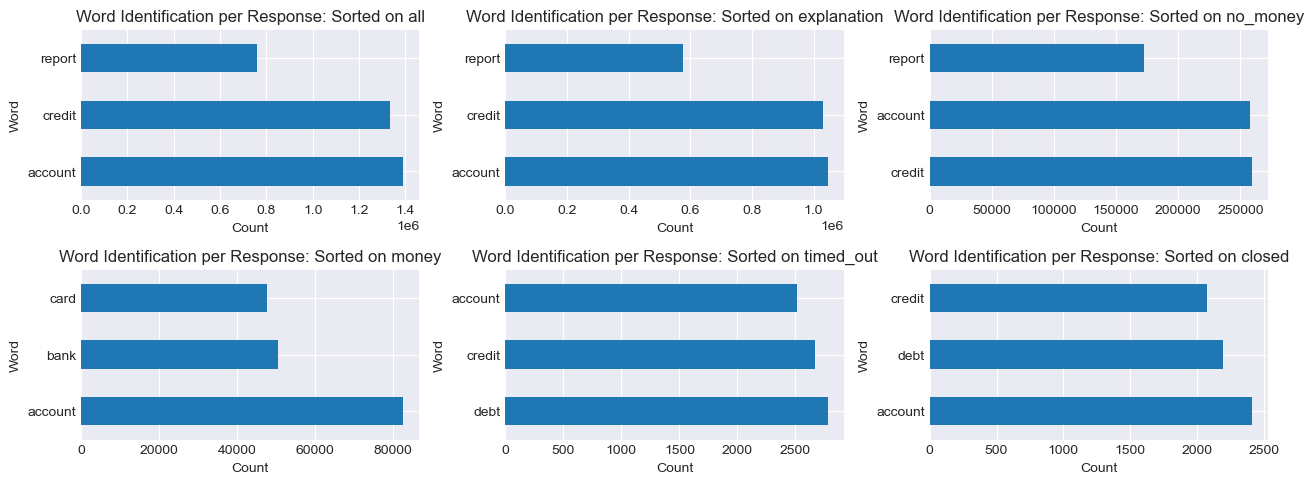

In [123]:
unique_words(word_counts)

In [87]:
import seaborn as sns

## 4. Are there unique words associated with the most negative and most positive company response?